In [1]:
import os
import numpy as np
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def get_ge_from_fc(corr):
    """
    Compute global efficiency from functional connectivity
    """
    nx_corr = nx.from_numpy_array(corr)
    ge = nx.global_efficiency(nx_corr)    
    return ge

def count_sub_overlap(measure):
    """
    Count overlapping subjects after sorting and calculate L1 distance
    """
    num_pipe = measure.shape[0]
    num_sub = measure.shape[1]
    sorted_sub = np.zeros([num_pipe, num_sub])
    
    for i in range(num_pipe):
        sorted_sub[i,:] = np.argsort(measure[i,:])
    
    # Count the overlapping subjects
    count = np.zeros(num_pipe*(num_pipe-1)//2)
    c = 0
    for i in range(num_pipe):
        for j in range(i+1,num_pipe):
            for k in range(29):
                if sorted_sub[i,k]==sorted_sub[j,k]:
                    count[c] = count[c]+1
            c = c+1
    
    # Calculate distance
    distance = np.zeros(num_pipe*(num_pipe-1)//2)
    c = 0
    for i in range(num_pipe):
        for j in range(i+1,num_pipe):
            distance[c] = np.sum(np.abs(sorted_sub[i,:] - sorted_sub[j,:])) 
            c = c+1
    
    return count/num_sub, distance/num_sub

In [3]:
# load subject list
sub_list = []
with open('/Users/xinhui.li/Documents/reproducibility/reproducibility/review/hbn/low_motion_30.txt') as f:
    lines = f.readlines()

for line in lines:
    line.strip('\n')
    line.strip('sub-')
    sub_list.append(line[4:11])

sub_list.sort()

In [4]:
dir="/Users/xinhui.li/Documents/reproducibility/LA/Reproducibility_Analysis/ROI/ROI_Schaefer200"

# HBN
pipe_list=["hbn_cpac_abcd", "hbn_cpac_ccs", "hbn_cpac_default", "hbn_cpac_fmriprep"]
mean_pearson_corr_list = []
ge = np.zeros( (4, 4, 29) )

for i, pipe in enumerate(pipe_list):
    pearson_corr_triu_list = []
    # load ROI and calculate correlation
    for j, sub in enumerate(sub_list):
        sub_path=os.path.join(dir, pipe, f"sub-{sub}_ses-1.1D")
        roi=np.genfromtxt(sub_path).T
        corr = np.corrcoef(roi)
        # P.S. a different way to calculate correlation coefficient
        # from nilearn import connectome as nlc
        # cm = nlc.ConnectivityMeasure(kind='correlation')
        # mat = cm.fit_transform([roi.T])
        percs = np.percentile(np.abs(corr), [90, 95, 97.5])

        sparse_corrs = []
        for p in percs:
            locs = np.abs(corr) >= p
            sparse_corrs += [locs*corr]

        ge[0, i, j] = get_ge_from_fc(sparse_corrs[0])
        ge[1, i, j] = get_ge_from_fc(sparse_corrs[1])
        ge[2, i, j] = get_ge_from_fc(sparse_corrs[2])
        ge[3, i, j] = get_ge_from_fc(corr)

        corr_triu = corr[np.triu_indices(corr.shape[0], 1)]
        pearson_corr_triu_list.append(corr_triu)

    pearson_corr_triu = np.array(pearson_corr_triu_list) # 29x19900
    mean_pearson_corr_list.append(np.mean(pearson_corr_triu, axis=1))

mean_pearson_corr = np.array(mean_pearson_corr_list)

In [5]:
common_gc, distance_gc = count_sub_overlap(mean_pearson_corr)
common_ge90, distance_ge90 = count_sub_overlap(ge[0,:,:])
common_ge95, distance_ge95 = count_sub_overlap(ge[1,:,:])
common_ge97, distance_ge97 = count_sub_overlap(ge[2,:,:])
common = np.concatenate([np.expand_dims(common_gc,1), np.expand_dims(common_ge90,1), np.expand_dims(common_ge95,1), np.expand_dims(common_ge97,1)], 1)

print(f"The average overlap of subjects: global connectivity {np.mean(common_gc):.4f}; global efficiency with threshold 90% {np.mean(common_ge90):.4f}; 95% {np.mean(common_ge95):.4f}; 97% {np.mean(common_ge97):.4f}")
print(f"The L1 distance of subject sorting: global connectivity {np.mean(distance_gc):.2f}; global efficiency with threshold 90% {np.mean(distance_ge90):.2f}; 95% {np.mean(distance_ge95):.2f}; 97% {np.mean(distance_ge97):.2f}")

The average overlap of subjects: global connectivity 0.3448; global efficiency with threshold 90% 0.1839; 95% 0.1264; 97% 0.1149
The L1 distance of subject sorting: global connectivity 5.82; global efficiency with threshold 90% 7.76; 95% 8.55; 97% 7.99


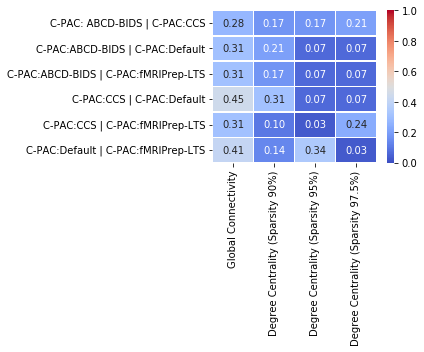

In [6]:
fig, ax = plt.subplots( figsize=(6,5) )

xticks = np.arange(0.5, 4.5, 1)
xticklabels = ['Global Connectivity', 'Degree Centrality (Sparsity 90%)', 'Degree Centrality (Sparsity 95%)', 'Degree Centrality (Sparsity 97.5%)']

yticks = np.arange(0.5, 6.5, 1)
yticklabels = ['C-PAC: ABCD-BIDS | C-PAC:CCS', 'C-PAC:ABCD-BIDS | C-PAC:Default', 'C-PAC:ABCD-BIDS | C-PAC:fMRIPrep-LTS', 'C-PAC:CCS | C-PAC:Default', 'C-PAC:CCS | C-PAC:fMRIPrep-LTS', 'C-PAC:Default | C-PAC:fMRIPrep-LTS']

sns.heatmap(common, annot=True, linewidths=.5, fmt=".2f", cmap="coolwarm", vmin=0, vmax=1, xticklabels=xticklabels, yticklabels=yticklabels, ax = ax)
ax.set_xticks(xticks)
ax.set_yticks(yticks)

plt.tight_layout()
fig.savefig('graph/hbn_heatmap.png',dpi=200)

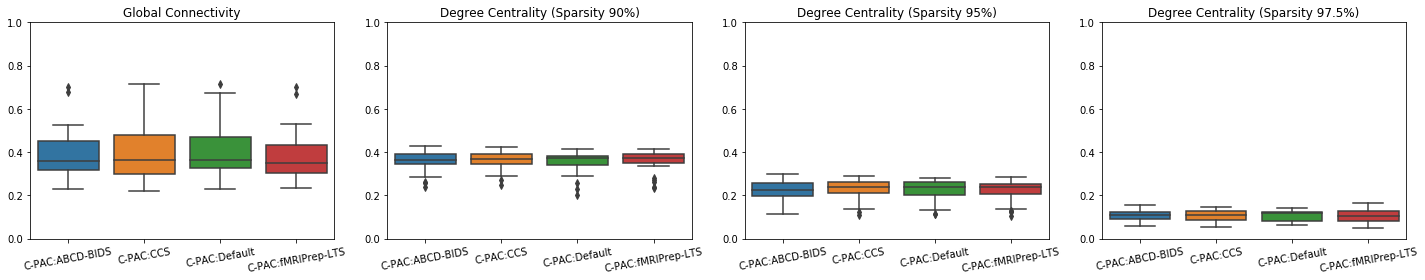

In [7]:
# violin plot, KS test
fig, axes = plt.subplots(1, 4, figsize=(20,4))

pipeline_list = ['C-PAC:ABCD-BIDS', 'C-PAC:CCS', 'C-PAC:Default', 'C-PAC:fMRIPrep-LTS']
rotation_angle=10

sns.boxplot(data = mean_pearson_corr.T, ax=axes[0])
axes[0].set_title('Global Connectivity')
axes[0].set_xticklabels(pipeline_list, rotation=rotation_angle)
axes[0].set_ylim([0,1])

sns.boxplot(data = ge[0,:,:].T, ax=axes[1])
axes[1].set_title('Degree Centrality (Sparsity 90%)')
axes[1].set_xticklabels(pipeline_list, rotation=rotation_angle)
axes[1].set_ylim([0,1])

sns.boxplot(data = ge[1,:,:].T, ax=axes[2])
axes[2].set_title('Degree Centrality (Sparsity 95%)')
axes[2].set_xticklabels(pipeline_list, rotation=rotation_angle)
axes[2].set_ylim([0,1])

sns.boxplot(data = ge[2,:,:].T, ax=axes[3])
axes[3].set_title('Degree Centrality (Sparsity 97.5%)')
axes[3].set_xticklabels(pipeline_list, rotation=rotation_angle)
axes[3].set_ylim([0,1])

plt.tight_layout()
fig.savefig('graph/hbn_box.png',dpi=200)

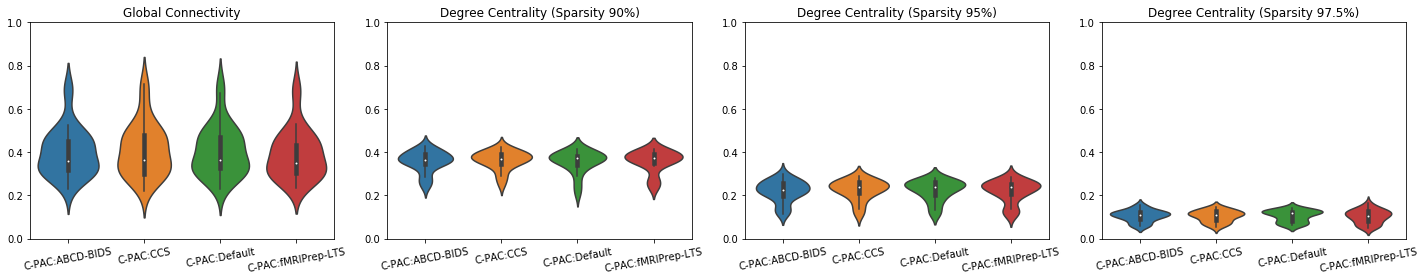

In [8]:
fig, axes = plt.subplots(1, 4, figsize=(20,4))

rotation_angle=10

sns.violinplot(data = mean_pearson_corr.T, ax=axes[0])
axes[0].set_title('Global Connectivity')
axes[0].set_xticklabels(pipeline_list, rotation=rotation_angle)
axes[0].set_ylim([0,1])

sns.violinplot(data = ge[0,:,:].T, ax=axes[1])
axes[1].set_title('Degree Centrality (Sparsity 90%)')
axes[1].set_xticklabels(pipeline_list, rotation=rotation_angle)
axes[1].set_ylim([0,1])

sns.violinplot(data = ge[1,:,:].T, ax=axes[2])
axes[2].set_title('Degree Centrality (Sparsity 95%)')
axes[2].set_xticklabels(pipeline_list, rotation=rotation_angle)
axes[2].set_ylim([0,1])

sns.violinplot(data = ge[2,:,:].T, ax=axes[3])
axes[3].set_title('Degree Centrality (Sparsity 97.5%)')
axes[3].set_xticklabels(pipeline_list, rotation=rotation_angle)
axes[3].set_ylim([0,1])

plt.tight_layout()
fig.savefig('graph/hbn_violin.png',dpi=200)

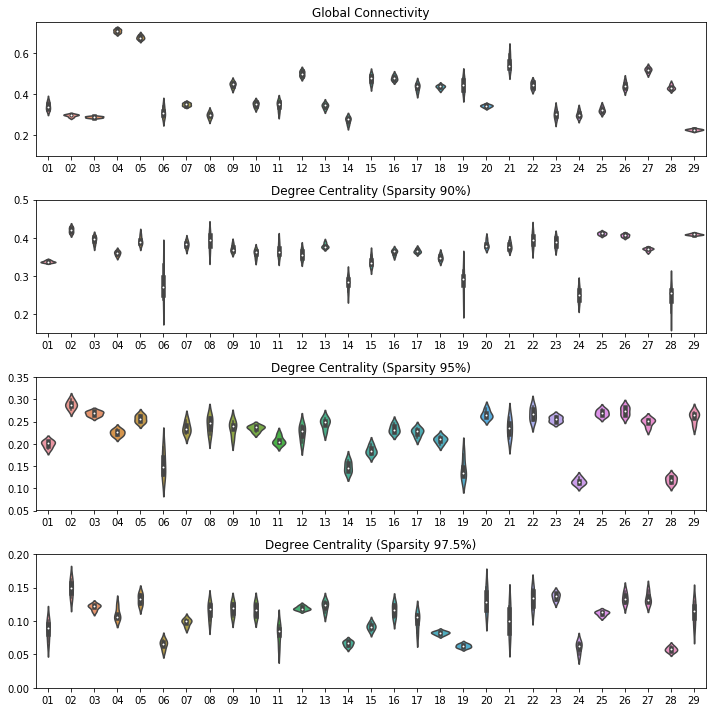

In [9]:
fig, axes = plt.subplots(4, 1, figsize=(10,10))

rotation_angle = 0

sub_list = []
for i in range(29):
    sub_id = f'{i+1}'
    sub_id = sub_id.zfill(2)
    sub_list.append(f'{sub_id}')

sns.violinplot(data = mean_pearson_corr, ax=axes[0])
axes[0].set_title('Global Connectivity')
axes[0].set_xticklabels(sub_list,rotation=rotation_angle)
axes[0].set_ylim([0.1,0.75])
# axes[0].set_ylim([0,1])

sns.violinplot(data = ge[0,:,:], ax=axes[1])
axes[1].set_title('Degree Centrality (Sparsity 90%)')
axes[1].set_xticklabels(sub_list,rotation=rotation_angle)
axes[1].set_ylim([0.15,0.5])
# axes[1].set_ylim([0,1])

sns.violinplot(data = ge[1,:,:], ax=axes[2])
axes[2].set_title('Degree Centrality (Sparsity 95%)')
axes[2].set_xticklabels(sub_list,rotation=rotation_angle)
axes[2].set_ylim([0.05,0.35])
# axes[2].set_ylim([0,1])

sns.violinplot(data = ge[2,:,:], ax=axes[3])
axes[3].set_title('Degree Centrality (Sparsity 97.5%)')
axes[3].set_xticklabels(sub_list,rotation=rotation_angle)
axes[3].set_ylim([0,0.2])
# axes[3].set_ylim([0,1])

plt.tight_layout()
fig.savefig('graph/hbn_violin_individual.png',dpi=200)

In [10]:
dir="/Users/xinhui.li/Documents/reproducibility/LA/Reproducibility_Analysis/ROI/ROI_Schaefer200"

# HNU
sub_list=os.listdir( os.path.join(dir, "cpac_default_v1.8") )
pipe_list=['ABCD','ccs_rerun','cpac_default_v1.8','dpabi','fmriprep_default']
mean_pearson_corr_list = []
ge = np.zeros( (4,5,29) )

for i, pipe in enumerate(pipe_list):
    pearson_corr_triu_list = []
    # load ROI and calculate correlation
    for j, sub in enumerate(sub_list):
        sub_path=os.path.join(dir, pipe, sub)
        roi=np.genfromtxt(sub_path).T
        corr = np.corrcoef(roi)
        
        percs = np.percentile(np.abs(corr), [90, 95, 97.5])

        sparse_corrs = []
        for p in percs:
            locs = np.abs(corr) >= p
            sparse_corrs += [locs*corr]

        ge[0, i, j] = get_ge_from_fc(sparse_corrs[0])
        ge[1, i, j] = get_ge_from_fc(sparse_corrs[1])
        ge[2, i, j] = get_ge_from_fc(sparse_corrs[2])
        ge[3, i, j] = get_ge_from_fc(corr)

        corr_triu = corr[np.triu_indices(corr.shape[0], 1)]
        pearson_corr_triu_list.append(corr_triu)
    
    pearson_corr_triu = np.array(pearson_corr_triu_list) # 29x19900
    mean_pearson_corr_list.append(np.mean(pearson_corr_triu, axis=1))

mean_pearson_corr = np.array(mean_pearson_corr_list)

In [11]:
common_gc, distance_gc = count_sub_overlap(mean_pearson_corr)
common_ge90, distance_ge90 = count_sub_overlap(ge[0,:,:])
common_ge95, distance_ge95 = count_sub_overlap(ge[1,:,:])
common_ge97, distance_ge97 = count_sub_overlap(ge[2,:,:])
common = np.concatenate([np.expand_dims(common_gc,1), np.expand_dims(common_ge90,1), np.expand_dims(common_ge95,1), np.expand_dims(common_ge97,1)], 1)

print(f"The average overlap of subjects: global connectivity {np.mean(common_gc):.4f}; global efficiency with threshold 90% {np.mean(common_ge90):.4f}; 95% {np.mean(common_ge95):.4f}; 97% {np.mean(common_ge97):.4f}")
print(f"The L1 distance of subject sorting: global connectivity {np.mean(distance_gc):.2f}; global efficiency with threshold 90% {np.mean(distance_ge90):.2f}; 95% {np.mean(distance_ge95):.2f}; 97% {np.mean(distance_ge97):.2f}")

The average overlap of subjects: global connectivity 0.3379; global efficiency with threshold 90% 0.1310; 95% 0.1103; 97% 0.1207
The L1 distance of subject sorting: global connectivity 7.26; global efficiency with threshold 90% 8.67; 95% 9.74; 97% 8.20


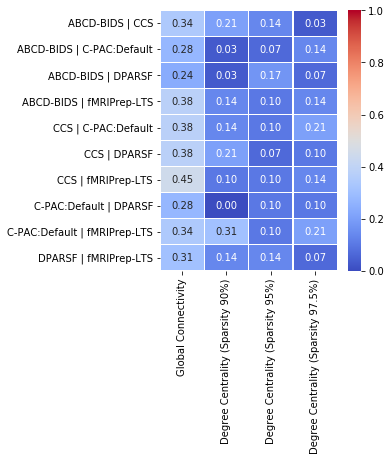

In [12]:
fig, ax = plt.subplots( figsize=(5.5,6.5) )

xticks = np.arange(0.5, 4.5, 1)
xticklabels = ['Global Connectivity', 'Degree Centrality (Sparsity 90%)', 'Degree Centrality (Sparsity 95%)', 'Degree Centrality (Sparsity 97.5%)']

yticks = np.arange(0.5, 10.5, 1)
yticklabels = ['ABCD-BIDS | CCS', 'ABCD-BIDS | C-PAC:Default', \
    'ABCD-BIDS | DPARSF', 'ABCD-BIDS | fMRIPrep-LTS', \
    'CCS | C-PAC:Default', 'CCS | DPARSF', 'CCS | fMRIPrep-LTS', \
    'C-PAC:Default | DPARSF', 'C-PAC:Default | fMRIPrep-LTS', 'DPARSF | fMRIPrep-LTS']

sns.heatmap(common, annot=True, linewidths=.5, fmt=".2f", cmap="coolwarm", vmin=0, vmax=1, xticklabels=xticklabels, yticklabels=yticklabels, ax = ax)
ax.set_xticks(xticks)
# ax.set_xticklabels(xticklabels, rotation=75)
ax.set_yticks(yticks)

plt.tight_layout()
fig.savefig('graph/hnu_heatmap.png',dpi=200)

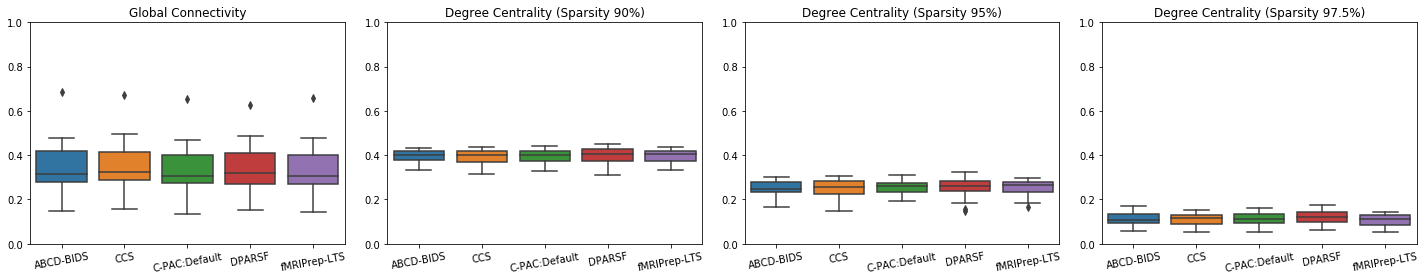

In [13]:
fig, axes = plt.subplots(1, 4, figsize=(20,4))

pipeline_list = ['ABCD-BIDS', 'CCS', 'C-PAC:Default', 'DPARSF', 'fMRIPrep-LTS']
rotation_angle = 10

sns.boxplot(data = mean_pearson_corr.T, ax=axes[0])
axes[0].set_title('Global Connectivity')
axes[0].set_xticklabels(pipeline_list, rotation=rotation_angle)
axes[0].set_ylim([0,1])

sns.boxplot(data = ge[0,:,:].T, ax=axes[1])
axes[1].set_title('Degree Centrality (Sparsity 90%)')
axes[1].set_xticklabels(pipeline_list, rotation=rotation_angle)
axes[1].set_ylim([0,1])

sns.boxplot(data = ge[1,:,:].T, ax=axes[2])
axes[2].set_title('Degree Centrality (Sparsity 95%)')
axes[2].set_xticklabels(pipeline_list, rotation=rotation_angle)
axes[2].set_ylim([0,1])

sns.boxplot(data = ge[2,:,:].T, ax=axes[3])
axes[3].set_title('Degree Centrality (Sparsity 97.5%)')
axes[3].set_xticklabels(pipeline_list, rotation=rotation_angle)
axes[3].set_ylim([0,1])

plt.tight_layout()
fig.savefig('graph/hnu_box.png',dpi=200)

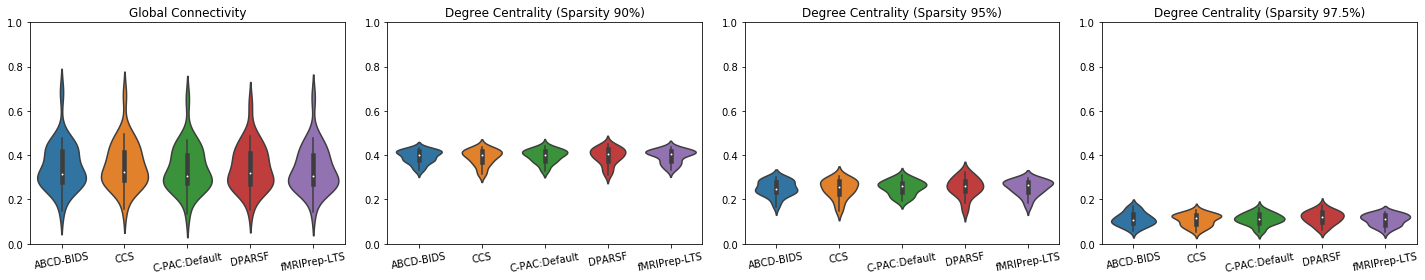

In [14]:
fig, axes = plt.subplots(1, 4, figsize=(20,4))

rotation_angle = 10

sns.violinplot(data = mean_pearson_corr.T, ax=axes[0])
axes[0].set_title('Global Connectivity')
axes[0].set_xticklabels(pipeline_list, rotation=rotation_angle)
axes[0].set_ylim([0,1])

sns.violinplot(data = ge[0,:,:].T, ax=axes[1])
axes[1].set_title('Degree Centrality (Sparsity 90%)')
axes[1].set_xticklabels(pipeline_list, rotation=rotation_angle)
axes[1].set_ylim([0,1])

sns.violinplot(data = ge[1,:,:].T, ax=axes[2])
axes[2].set_title('Degree Centrality (Sparsity 95%)')
axes[2].set_xticklabels(pipeline_list, rotation=rotation_angle)
axes[2].set_ylim([0,1])

sns.violinplot(data = ge[2,:,:].T, ax=axes[3])
axes[3].set_title('Degree Centrality (Sparsity 97.5%)')
axes[3].set_xticklabels(pipeline_list, rotation=rotation_angle)
axes[3].set_ylim([0,1])

plt.tight_layout()
fig.savefig('graph/hnu_violin.png',dpi=200)

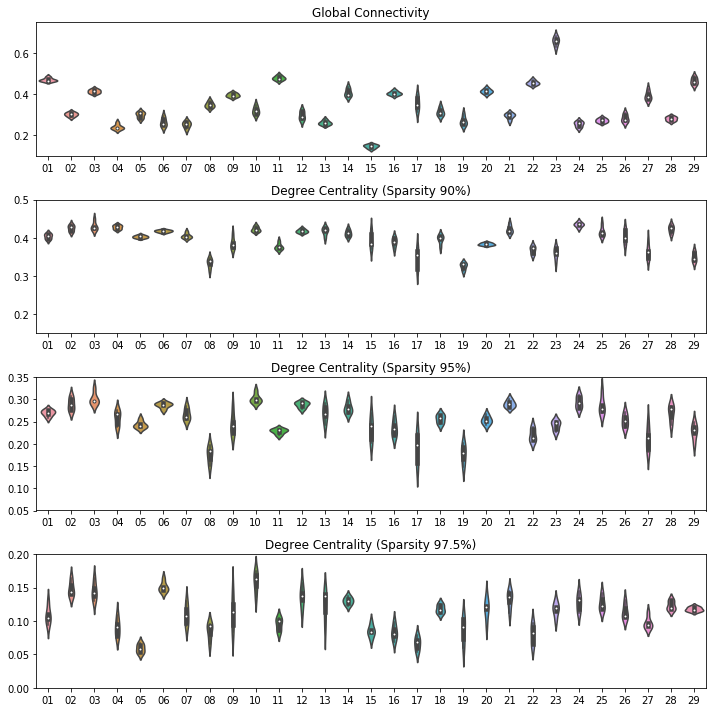

In [15]:
fig, axes = plt.subplots(4, 1, figsize=(10,10))

rotation_angle = 0

sub_list = []
for i in range(29):
    sub_id = f'{i+1}'
    sub_id = sub_id.zfill(2)
    sub_list.append(f'{sub_id}')

sns.violinplot(data = mean_pearson_corr, ax=axes[0])
axes[0].set_title('Global Connectivity')
axes[0].set_xticklabels(sub_list,rotation=rotation_angle)
axes[0].set_ylim([0.1,0.75])
# axes[0].set_ylim([0,1])

sns.violinplot(data = ge[0,:,:], ax=axes[1])
axes[1].set_title('Degree Centrality (Sparsity 90%)')
axes[1].set_xticklabels(sub_list,rotation=rotation_angle)
axes[1].set_ylim([0.15,0.5])
# axes[1].set_ylim([0,1])

sns.violinplot(data = ge[1,:,:], ax=axes[2])
axes[2].set_title('Degree Centrality (Sparsity 95%)')
axes[2].set_xticklabels(sub_list,rotation=rotation_angle)
axes[2].set_ylim([0.05,0.35])
# axes[2].set_ylim([0,1])

sns.violinplot(data = ge[2,:,:], ax=axes[3])
axes[3].set_title('Degree Centrality (Sparsity 97.5%)')
axes[3].set_xticklabels(sub_list,rotation=rotation_angle)
axes[3].set_ylim([0,0.2])
# axes[3].set_ylim([0,1])

plt.tight_layout()
fig.savefig('graph/hnu_violin_individual.png',dpi=200)